# Hierarchical Graph Representation Learning with Differentiable Pooling

Links to the original paper:
* ArXiv: <https://arxiv.org/abs/1806.08804>
* Code Repository: <https://github.com/RexYing/diffpool>

## Toy Example: 1-Layer Diffpool

In the following cells the mathematical formulas of Difffpool are explained with a small example.

Consider a small graph with 5 nodes, 5 edges and each node has two features. In this example we use a one layer Diffpool model to reduce this graph to 2 clusters with new aggregated embeddings. As GNNs we use GraphSAGE for both the embedding and pooling models.

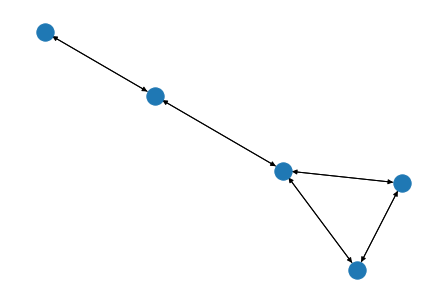

tensor([[ 2.5174,  0.4046],
        [ 1.5878, -0.2628],
        [-0.7163,  0.1374],
        [-0.0331,  0.1163],
        [ 0.6048, -1.4802]])

In [17]:
import torch as th
import torch.nn as nn
import matplotlib.pyplot as plt
import networkx as nx
import dgl

nx_G = nx.Graph()
nx_G.add_edges_from([(1, 2), (2, 3), (3, 4), (3, 5), (4, 5)])

g = dgl.from_networkx(nx_G)
X = th.randn(5, 2)

nx.draw(dgl.to_networkx(g))
plt.show()
X

### Compute cluster assignments & node embeddings

The first step is to compute the cluster assignments and associated embeddings of the aggregated nodes. We simply apply the formulas provided in the paper:

\begin{align*}
Z = \mathrm{GNN}_{\mathrm{embed}}(A, X) \\
S = \mathrm{softmax}(\mathrm{GNN}_{\mathrm{pool}}(A, X))
\end{align*}

In [18]:
from dgl.nn.pytorch import DenseSAGEConv
from torch.nn.functional import softmax

embed = DenseSAGEConv(2, 2, norm=nn.BatchNorm1d(2))
pool = DenseSAGEConv(2, 2, norm=nn.BatchNorm1d(2))

A = g.adj().to_dense()
Z = embed(A, X)
S = softmax(pool(A, X), dim=-1)

Z, S

(tensor([[-1.6809,  1.8390],
         [-0.5681,  0.1459],
         [ 0.4172, -0.2276],
         [ 0.9159, -0.8786],
         [ 0.9159, -0.8786]], grad_fn=<NativeBatchNormBackward0>),
 tensor([[0.0410, 0.9590],
         [0.1792, 0.8208],
         [0.7314, 0.2686],
         [0.8624, 0.1376],
         [0.8624, 0.1376]], grad_fn=<SoftmaxBackward0>))

### Construct the new representation graph

In the second step we now have to construct the new graph. To do so, we first calculate the embeddings $X'$ for each cluster and then the new adjacency matrix $A'$ that connects the clusters.

Again, we simply use the formulas from the paper in our example:

\begin{align*}
X' = S^T Z \\
A' = S^T A S
\end{align*}

In [16]:
X_new = S.transpose(-1, -2) @ Z
A_new = S.transpose(-1, -2) @ A @ S

X_new, A_new

(tensor([[ 1.7940, -1.8213],
         [-1.7940,  1.8213]], grad_fn=<MmBackward0>),
 tensor([[2.3359, 1.7307],
         [1.7307, 4.2027]], grad_fn=<MmBackward0>))

Finally, we can take a look at the new graph. As already announced, we now have only two nodes that are connected by weighted edges and contain the embeddings from the nodes combined in them representatively in their new embeddings.

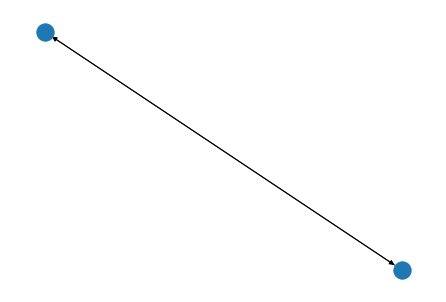

In [8]:
g_new = nx.from_numpy_matrix(A_new.detach().numpy(), create_using=nx.Graph)
g_new.remove_edges_from(nx.selfloop_edges(g_new))
nx.draw(g_new)
plt.show()

## Diffpool in practice: Graph classification of the ENZYMES datasets

In [10]:
from dgl.data import tu

dataset = tu.LegacyTUDataset(name="ENZYMES")
train_size = int(0.7 * len(dataset))
test_size = int(0.1 * len(dataset))
val_size = int(len(dataset) - train_size - test_size)

batch_size = 20

dataset_train, dataset_val, dataset_test = torch.utils.data.random_split(
    dataset, (train_size, val_size, test_size))
train_dataloader = dgl.dataloading.GraphDataLoader(dataset_train, batch_size=batch_size)
val_dataloader = dgl.dataloading.GraphDataLoader(dataset_val, batch_size=batch_size)
test_dataloader = dgl.dataloading.GraphDataLoader(dataset_test, batch_size=batch_size)

input_dim, label_dim, max_num_node = dataset.statistics()
print("++++++++++STATISTICS ABOUT THE DATASET")
print("dataset feature dimension is", input_dim)
print("dataset label dimension is", label_dim)
print("the max num node is", max_num_node)
print("number of graphs is", len(dataset))

Extracting file to /home/dstoll/.dgl/ENZYMES
++++++++++STATISTICS ABOUT THE DATASET
dataset feature dimension is 18
dataset label dimension is 6
the max num node is 126
number of graphs is 600


In [12]:
hidden_dim = 64
embedding_dim = 64
pool_ratio = 0.15

assign_dim = int(max_num_node * pool_ratio)
print("++++++++++MODEL STATISTICS++++++++")
print("model hidden dim is", hidden_dim)
print("model embedding dim for graph instance embedding", embedding_dim)
print("initial batched pool graph dim is", assign_dim)
activation = F.relu

++++++++++MODEL STATISTICS++++++++
model hidden dim is 64
model embedding dim for graph instance embedding 64
initial batched pool graph dim is 18


Number of nodes for each graph element in the batch: tensor([73, 27, 30, 20, 11])
Number of edges for each graph element in the batch: tensor([313, 141, 148,  96,  51])
The original graphs in the minibatch:
[Graph(num_nodes=73, num_edges=313,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=27, num_edges=141,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=30, num_edges=148,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=20, num_edges=96,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=11, num_edges=51,
      ndata_schemes={'label': Scheme(shape=(), dtype=to

In [7]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        g.ndata['h'] = h
        return dgl.mean_nodes(g, 'h')

In [9]:
# Create the model with given dimensions
model = GCN(dataset.dim_nfeats, 16, dataset.gclasses)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(20):
    for batched_graph, labels in train_dataloader:
        pred = model(batched_graph, batched_graph.ndata['attr'].float())
        loss = F.cross_entropy(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

num_correct = 0
num_tests = 0
for batched_graph, labels in test_dataloader:
    pred = model(batched_graph, batched_graph.ndata['attr'].float())
    num_correct += (pred.argmax(1) == labels).sum().item()
    num_tests += len(labels)

print('Test accuracy:', num_correct / num_tests)

Test accuracy: 0.09417040358744394
